## Contents

**EDA**
* [Distribution of classes](#Dataset-full-count,-Distribution-of-classes)
* [Hashtags](#Explore-hashtags-for-each-class)
* [Usernames](#Explore-Usernames)

**Data Preprocessing**
* [Clean and Tokenize](#Clean-data-and-tokenize)
* [Lemmatize](#Lemmatize-tokens)
* [Removing of StopWords](#Remove-stop-words-from-tokens)
* [Exploring Clean Tweets](#Check-Clean-Tweets)
* [Transform target label](#Transform-Target-Label)

[**Naive Bayes**](#Using-Naive-Bayes)
* [Different Vectorizers used](#Using-Tf-Idf-as-vectorizer)

[**Logistic Regression**](#Using-Logistic-Regression)
* [Feature importance](#Look-at-feature-importance-for-each-classes)
* [Logistic Regression without Blank Tweets](#Removing-blank-tweets)
* [Logistic Regression with Stopwords](#Logistic-Regression-with-Stopwords)

[**Prediction on Test Set**](#Test-on-actual-Test-set)
* [Hypothesis on prediction results (class 2)](#Exploring-prediction-for-class-2)


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import re
import string
import unidecode

from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import en_core_web_sm
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

C:\Users\Julene\Anaconda3\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
pd.set_option('display.max_colwidth', -1)

from IPython.display import display, HTML, display_html

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

C:\Users\Julene\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


### Load dataset

In [3]:
train = pd.read_csv("dataset_train.csv", engine='python')
train.head(10)

,id,Tweets,Label
0,7281,The jokes and puns are flying free in this camping episode.\n#mkr #mkr2015,none
1,7282,#MKR Lets see who the producers think are going to be better TV - Kat or Nikki and Katie??,none
2,7283,Praying Jac and Shaz do well! They're my faves. #MKR,none
3,7284,RT @realityraver: Pete Evans the Paleo Capitalist has had his cookbook pulled http://t.co/VubeLWZ9l9 #mkr,none
4,7285,If Kat and Andre stay tonight I will stop watching My Kitchen Rules. #mkr,none
5,7286,#mkr Kat is defining fair..... #hypocrite,none
6,7287,Twist in the plot.. The bottom 2 teams leave!! I think everyone would be happy!! #MKR,none
7,7288,"Doesn't anyone have a gif of Manu saying ""no you get out"" cos that would be awesome\n#mkr",none
8,7289,How Bianca puts up with Drasko is beyond me. #MKR,none
9,7290,What's Irene doing on #mkr?,none


### Dataset full count, Distribution of classes

In [4]:
train.shape

(12829, 3)

In [5]:
train.Label.value_counts()

none      8747
sexism    2534
racism    1548
Name: Label, dtype: int64

In [6]:
train.Label.value_counts(normalize = True)

none      0.681815
sexism    0.197521
racism    0.120664
Name: Label, dtype: float64

### Explore hashtags for each class
Should the '#' be kept?

In [7]:
hashtags = []
for i in train['Tweets']:
    tags = re.findall(r'(#\w+)', i.lower())
    hashtags.append(" ".join(tags))

In [8]:
train['hashtags'] = hashtags

In [9]:
train[(train['Label'] == 'none') & (train['hashtags'] != '') ]['hashtags'].value_counts()[:10]

#mkr                   1003
#stopwadhwa2015        46  
#mkr #mkr2015          43  
#yesallwomen           25  
#islam                 22  
#mkr #hungrycampers    22  
#gamergate             19  
#mkr2015 #mkr          18  
#isis                  13  
#ggautoblocker         11  
Name: hashtags, dtype: int64

In [10]:
train[(train['Label'] == 'none') & (train['hashtags'] == '#islam')].head(10)

,id,Tweets,Label,hashtags
4892,12173,@imkhan1104 Here is what #Islam thinks about Merkel's democracy. http://t.co/mwDPks3JP7,none,#islam
4902,12183,What is Sharia law. Here are some of its rules. #Islam http://t.co/fI49gUT884,none,#islam
5060,12341,"So, will the French terrorists be heading to Turkey where Erdogan can protect them and send them safely to ISIS? #Islam",none,#islam
5073,12354,@SafeensS And the dress is only symbolic of the broader sexism. #Islam http://t.co/SdI0ERuYia,none,#islam
5075,12356,Here are some of the elements of Sharia law. #Islam http://t.co/L5K7ESAVCi,none,#islam
5126,12407,@NiyamaKandeGrif This is Islamophobia. #Islam http://t.co/wVzM9DtMcm,none,#islam
5228,12509,"@1oNo1_Islam Chat now, they are waiting for you. http://t.co/ATdf0IiETD #Islam",none,#islam
5267,12548,@NNdabbour64 The punishment for apostacy in #Islam is death. Here is the proof. http://t.co/dDajGBXvCZ,none,#islam
5287,12568,"We may have to do business with the Saudis, but we don't have to pretend that they are anything but a backwards Islamic dictatorship. #Islam",none,#islam
5969,13250,"Finally, an Egyptian broadcaster says what the Politically correct American and European left refuse to say. http://t.co/NzEVQaoAPv #Islam",none,#islam


In [11]:
train[(train['Label'] == 'sexism') & (train['hashtags'] != '') ]['hashtags'].value_counts()[:10]

#mkr                        139
#notsexist                  90 
#questionsformen            23 
#gamergate                  14 
#womenagainstfeminism       14 
#adviceforyoungfeminists    9  
#mkr #mkr2015               9  
#sorrynotsorry              5  
#mkr2015 #mkr               5  
#twitterfeminism            5  
Name: hashtags, dtype: int64

In [12]:
train[(train['Label'] == 'sexism') & (train['hashtags'] == '#womenagainstfeminism')].head(10)

,id,Tweets,Label,hashtags
10394,2661,"@aamattyhealy Bet I can prove that you, like most feminists, oppose equality quickly, A B or C? #WomenAgainstFeminism http://t.co/QFTAQLYtNd",sexism,#womenagainstfeminism
10457,2724,"RT @asredasmyhair: My response 2 feminists' ""not all feminists are like that...feminism is about equality"" argmnt #WomenAgainstFeminism htt…",sexism,#womenagainstfeminism
10557,2824,".@TheGags29 If feminists knew how many women ""internalized"" my ""misogyny"" theyd need safe space #WomenAgainstFeminism http://t.co/qT4laFeK7u",sexism,#womenagainstfeminism
10570,2837,.@RealTrumpsFeels Evidently Twit'n'Run feminist coward @Auragasmic unblocks me long enough to reply &amp; then reblocks me #WomenAgainstFeminism,sexism,#womenagainstfeminism
10752,3019,RT @asredasmyhair: Just going to keep this here so I can direct fems to it when they want to argue. My #WomenAgainstFeminism blog http://t.…,sexism,#womenagainstfeminism
10944,3211,"RT @GreyUmopepisdn: When a radical feminist or SJW tries to argue with you, try these tips. #WomenAgainstFeminism http://t.co/UP62bkHAEL",sexism,#womenagainstfeminism
11078,3345,RT @victorymonk: If she is not one of #WomenAgainstFeminism I don't know who is: https://t.co/um5svJgazu,sexism,#womenagainstfeminism
11081,3348,"Yeah, uh, @CharlTaylorPage #WomenAgainstFeminism aren't bigots who hate men and don't mind sharing equality w them like you hypocrites. FYI.",sexism,#womenagainstfeminism
11083,3350,RT @ChloeSeashell: Not a fan of this comic (too SJW-ish for me) but this is spot-on. http://t.co/fchqFYHkDB #WomenAgainstFeminism http://t.…,sexism,#womenagainstfeminism
11122,3389,RT @victorymonk: That awkward moment when a comment is more informative than the article. http://t.co/mGSaftUnXs #WomenAgainstFeminism http…,sexism,#womenagainstfeminism


In [13]:
train[(train['Label'] == 'racism') & (train['hashtags'] != '') ]['hashtags'].value_counts()[:10]

#islam                       49
#ferguson                    5 
#mkr                         4 
#tikrit                      2 
#islam #daesh                2 
#isis                        2 
#islam #iraq                 2 
#islamloveswomen #iwd2015    1 
#pmlive                      1 
#egyptian                    1 
Name: hashtags, dtype: int64

### Explore Usernames

In [14]:
usernames = [" ".join(re.findall(r'@[\w+]*', i.lower())) for i in train['Tweets']]

In [15]:
train['usernames'] = usernames
train.head(20)

,id,Tweets,Label,hashtags,usernames
0,7281,The jokes and puns are flying free in this camping episode.\n#mkr #mkr2015,none,#mkr #mkr2015,
1,7282,#MKR Lets see who the producers think are going to be better TV - Kat or Nikki and Katie??,none,#mkr,
2,7283,Praying Jac and Shaz do well! They're my faves. #MKR,none,#mkr,
3,7284,RT @realityraver: Pete Evans the Paleo Capitalist has had his cookbook pulled http://t.co/VubeLWZ9l9 #mkr,none,#mkr,@realityraver
4,7285,If Kat and Andre stay tonight I will stop watching My Kitchen Rules. #mkr,none,#mkr,
5,7286,#mkr Kat is defining fair..... #hypocrite,none,#mkr #hypocrite,
6,7287,Twist in the plot.. The bottom 2 teams leave!! I think everyone would be happy!! #MKR,none,#mkr,
7,7288,"Doesn't anyone have a gif of Manu saying ""no you get out"" cos that would be awesome\n#mkr",none,#mkr,
8,7289,How Bianca puts up with Drasko is beyond me. #MKR,none,#mkr,
9,7290,What's Irene doing on #mkr?,none,#mkr,


In [16]:
train[train['Label'] == 'racism'].usernames.value_counts()[:10]

                                                      48
@discerningmumin                                      40
@vandaliser @sajid_fairooz @israeliregime             36
@qoloob4 @vandaliser @sajid_fairooz @israeliregime    32
@dankmtl                                              27
@maxblumenthal                                        23
@harmlesstree2                                        22
@lifeinkhilafah                                       22
@truaemusic                                           20
@obsurfer84                                           18
Name: usernames, dtype: int64

In [17]:
train[train['Label'] == 'sexism'].usernames.value_counts()[:10]

                             180
@blackopal80                 13 
@uberfeminist                10 
@asredasmyhair               10 
@shaner38                    10 
@mykitchenrules              8  
@comattwow @chubssays        8  
@dreysander1                 8  
@anniekfox                   8  
@feministlah @greenweiner    8  
Name: usernames, dtype: int64

#### Thoughts on usernames:
- Usernames might be an indicator (and the only indicator of the document) for the label 
- e.g. '@israeliregime' for racism, '@uberfeminist' for sexism
- They will still be taken out during cleaning to reduce noise in vocab

# Data Preprocessing

### Clean data and tokenize
- Cleaning: Remove punctuation (incl. #), hyperlinks, usernames (word after @), word accents. Lowercase tweets 
- Tokenize: Using TweetTokenizer

In [18]:
tknzr = TweetTokenizer()

def clean_tokenizer(column):
    
    # Clean tweets
    clean = [i.lower() for i in column] ## lowercase tweets
    clean = [re.sub(r'@[\w+]*', '', i) for i in clean] ## remove usernames
    clean = [unidecode.unidecode(i) for i in clean] ## remove accent characters
    clean = [i.translate(str.maketrans('', '', string.punctuation)) for i in clean] ## remove punctuation
    clean = [re.sub(r'(http\w+)', '', i) for i in clean] ## remove hyperlinks
    clean = [re.sub(r'\d+', '', i ) for i in clean] ## remove numbers
    
    # Tokenize tweets
    all_tokens = [tknzr.tokenize(t) for t in clean]
    
    return all_tokens

In [19]:
clean_tokens = clean_tokenizer(train['Tweets'])

### Lemmatize tokens 
#### By mapping tokens to their POS tag, and getting the base POS (using first alphabet)

In [20]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

In [21]:
tweets_lemmatized = [[lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tweet] for tweet in clean_tokens]

### Remove stop words from tokens
#### Includes word 'not' based on Research Paper

In [22]:
stopword_list = stopwords.words('english')
stopword_list.remove('not')

In [23]:
stopword_list[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [24]:
# remove stopwords (excl. "not") and remove 'rt'
tweets_train = [[w for w in t if w not in stopword_list and w != ('rt')] for t in tweets_lemmatized]

In [25]:
# joining it back to the df

train['tweets_train'] = tweets_train
train['tweets_train'] = train['tweets_train'].apply(lambda x: ' '.join([w for w in x]))
train.head(10)

,id,Tweets,Label,hashtags,usernames,tweets_train
0,7281,The jokes and puns are flying free in this camping episode.\n#mkr #mkr2015,none,#mkr #mkr2015,,joke pun fly free camp episode mkr mkr
1,7282,#MKR Lets see who the producers think are going to be better TV - Kat or Nikki and Katie??,none,#mkr,,mkr let see producer think go well tv kat nikki katie
2,7283,Praying Jac and Shaz do well! They're my faves. #MKR,none,#mkr,,pray jac shaz well theyre faves mkr
3,7284,RT @realityraver: Pete Evans the Paleo Capitalist has had his cookbook pulled http://t.co/VubeLWZ9l9 #mkr,none,#mkr,@realityraver,pete evans paleo capitalist cookbook pull mkr
4,7285,If Kat and Andre stay tonight I will stop watching My Kitchen Rules. #mkr,none,#mkr,,kat andre stay tonight stop watch kitchen rule mkr
5,7286,#mkr Kat is defining fair..... #hypocrite,none,#mkr #hypocrite,,mkr kat define fair hypocrite
6,7287,Twist in the plot.. The bottom 2 teams leave!! I think everyone would be happy!! #MKR,none,#mkr,,twist plot bottom team leave think everyone would happy mkr
7,7288,"Doesn't anyone have a gif of Manu saying ""no you get out"" cos that would be awesome\n#mkr",none,#mkr,,doesnt anyone gif manu say get co would awesome mkr
8,7289,How Bianca puts up with Drasko is beyond me. #MKR,none,#mkr,,bianca put drasko beyond mkr
9,7290,What's Irene doing on #mkr?,none,#mkr,,whats irene mkr


### Check Clean Tweets

In [26]:
train['tweets_train'].value_counts()

                                                                     299
yes                                                                  23 
yup                                                                  17 
say                                                                  8  
lt                                                                   7  
                                                                    ..  
mosul christian pastor pauljacob sentence death behead isi iraq      1  
dont see u tweet sanitary towel getmeafuckinbeer slag                1  
im not sexist gd funny                                               1  
oh gosh parody                                                       1  
complaint abt dress code clearly base arousal not bodily autonomy    1  
Name: tweets_train, Length: 12225, dtype: int64

#### Where are the blanks coming from? 
What is the original tweet and can/should I remove them?

In [27]:
train[train['tweets_train'] == ''].Label.value_counts()

none      288
sexism    11 
Name: Label, dtype: int64

#### Thoughts on labels:
- When labels were annotated, there could be some context provided for the labeling not seen in text in the Tweets
- e.g. id 3534 is tweet with an attached picture about femenism (from the hyperlink)
- Else, if the following tweets were looked at independently, many of them (e.g. id 2972) seems neutral

- id 3504 might be categorized as such as annotation is also based on screen name (from research paper)

In [28]:
# clean tweets that are = '' and labelled 'sexism'
train[(train['tweets_train'] == '') & (train['Label'] == 'sexism')]

,id,Tweets,Label,hashtags,usernames,tweets_train
10495,2762,@BLUNTmoms How?,sexism,,@bluntmoms,
10705,2972,@ILivUndrUrBed @CarolynnEva No.,sexism,,@ilivundrurbed @carolynneva,
10765,3032,@thesledgetobias ?,sexism,,@thesledgetobias,
10856,3123,@purposelyflawed http://t.co/P6KTLT0XBZ,sexism,,@purposelyflawed,
10901,3168,"@AmarinaW You, too.",sexism,,@amarinaw,
10903,3170,@Menrwizards @Maniac_McGee27 @sara771987 Where is what from?,sexism,,@menrwizards @maniac_mcgee27 @sara771987,
10937,3204,RT @MrShikaki: @_shemmie_ @srhbutts @cainejw @_icze4r @Dylof_ http://t.co/f1uyMrdg5G,sexism,,@mrshikaki @_shemmie_ @srhbutts @cainejw @_icze4r @dylof_,
11169,3436,RT @Dekashoko: @theesadiemarie @MT8_9 http://t.co/3u6PChDs6f http://t.co/rgjJNBUtAo http://t.co/kAzMqMyn3Q http://t.co/ROSx40h9t6 http://t.…,sexism,,@dekashoko @theesadiemarie @mt8_9,
11193,3460,@g56yu What is that?,sexism,,@g56yu,
11237,3504,@beerandfeminism @Wyowanderer777 Which is?,sexism,,@beerandfeminism @wyowanderer777,


*The blanks are not removed for now*

### Top frequency of tokens for each class

#### for racism

In [29]:
top_tokens_r = train[train['Label'] == 'racism']['tweets_train'].str.split(expand=True).stack().value_counts()[:10]
top_tokens_r_norm = train[train['Label'] == 'racism']['tweets_train'].str.split(expand=True).stack().value_counts(normalize=True)[:10]

In [30]:
pd.DataFrame([top_tokens_r, round(top_tokens_r_norm*100, 2)]).T.rename(columns={0: "Token Count", 1: "Distribution (%)"})

,Token Count,Distribution (%)
muslim,485.0,3.66
islam,452.0,3.41
mohammed,169.0,1.28
not,143.0,1.08
isi,128.0,0.97
murder,128.0,0.97
jew,127.0,0.96
quran,111.0,0.84
religion,101.0,0.76
prophet,96.0,0.72


#### for sexism

In [31]:
top_tokens_s = train[train['Label'] == 'sexism']['tweets_train'].str.split(expand=True).stack().value_counts()[:10]
top_tokens_s_norm = train[train['Label'] == 'sexism']['tweets_train'].str.split(expand=True).stack().value_counts(normalize=True)[:10]

In [32]:
pd.DataFrame([top_tokens_s, round(top_tokens_s_norm*100, 2)]).T.rename(columns={0: "Token Count", 1: "Distribution (%)"})

,Token Count,Distribution (%)
not,978.0,4.29
sexist,935.0,4.10
im,696.0,3.05
woman,666.0,2.92
girl,264.0,1.16
female,236.0,1.04
call,226.0,0.99
mkr,224.0,0.98
dont,215.0,0.94
men,204.0,0.89


## Transform Target Label

In [33]:
le = preprocessing.LabelEncoder()
le.fit(train['Label'])
train['label_train'] = le.transform(train['Label'])

In [34]:
train.head(10)

,id,Tweets,Label,hashtags,usernames,tweets_train,label_train
0,7281,The jokes and puns are flying free in this camping episode.\n#mkr #mkr2015,none,#mkr #mkr2015,,joke pun fly free camp episode mkr mkr,0
1,7282,#MKR Lets see who the producers think are going to be better TV - Kat or Nikki and Katie??,none,#mkr,,mkr let see producer think go well tv kat nikki katie,0
2,7283,Praying Jac and Shaz do well! They're my faves. #MKR,none,#mkr,,pray jac shaz well theyre faves mkr,0
3,7284,RT @realityraver: Pete Evans the Paleo Capitalist has had his cookbook pulled http://t.co/VubeLWZ9l9 #mkr,none,#mkr,@realityraver,pete evans paleo capitalist cookbook pull mkr,0
4,7285,If Kat and Andre stay tonight I will stop watching My Kitchen Rules. #mkr,none,#mkr,,kat andre stay tonight stop watch kitchen rule mkr,0
5,7286,#mkr Kat is defining fair..... #hypocrite,none,#mkr #hypocrite,,mkr kat define fair hypocrite,0
6,7287,Twist in the plot.. The bottom 2 teams leave!! I think everyone would be happy!! #MKR,none,#mkr,,twist plot bottom team leave think everyone would happy mkr,0
7,7288,"Doesn't anyone have a gif of Manu saying ""no you get out"" cos that would be awesome\n#mkr",none,#mkr,,doesnt anyone gif manu say get co would awesome mkr,0
8,7289,How Bianca puts up with Drasko is beyond me. #MKR,none,#mkr,,bianca put drasko beyond mkr,0
9,7290,What's Irene doing on #mkr?,none,#mkr,,whats irene mkr,0


In [35]:
le.classes_

array(['none', 'racism', 'sexism'], dtype=object)

In [36]:
le.transform(le.classes_)

array([0, 1, 2])

## Split Training Data

In [37]:
X_train, X_test, y_train, y_test = train_test_split(train['tweets_train'], train['label_train'], test_size=0.2, random_state=12)

# Using Naive Bayes
### Baseline model

In [38]:
pipe = Pipeline(steps = [('vect', CountVectorizer()),
                        ('nb', MultinomialNB())])

In [39]:
param_grid = {
    'vect__analyzer': ['word', 'char', 'char_wb'],
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]
}

F1-macro will be used for GridSearchCV scoring method to focus on the minority classes.

In [40]:
search_nb = GridSearchCV(pipe, param_grid,
                         n_jobs=-1,
                         cv=10,
                         scoring='f1_macro',
                         refit=True)

In [41]:
search_nb.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'vect__analyzer': ['word', 'char', 'char_wb'],
                         'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]},
             scoring='f1_macro')

In [42]:
search_nb.best_score_

0.7495083592542107

In [43]:
search_nb.best_params_

{'vect__analyzer': 'word', 'vect__ngram_range': (1, 1)}

In [44]:
search_nb_pred = search_nb.predict(X_test)

In [45]:
print(metrics.classification_report(y_test, search_nb_pred, digits=3))

              precision    recall  f1-score   support

           0      0.851     0.910     0.880      1745
           1      0.701     0.686     0.693       318
           2      0.825     0.638     0.720       503

    accuracy                          0.829      2566
   macro avg      0.792     0.745     0.764      2566
weighted avg      0.827     0.829     0.825      2566



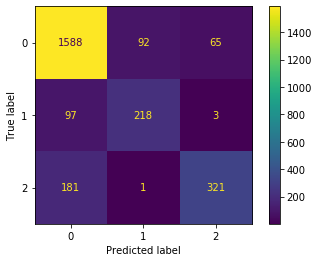

In [46]:
metrics.plot_confusion_matrix(search_nb, X_test, y_test)
plt.show()

### Using Tf-Idf as vectorizer

In [47]:
pipe = Pipeline(steps = [('tfidf', TfidfVectorizer()),
                        ('nb', MultinomialNB())])

In [48]:
param_grid = {
    'tfidf__max_df': (0.25, 0.5, 0.75, 1.0),
    'tfidf__analyzer': ['word', 'char', 'char_wb'],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]
}

In [49]:
nb_tfidf = GridSearchCV(pipe, param_grid,
                         n_jobs=-1,
                         cv=10,
                         scoring='f1_macro',
                         refit=True)

In [50]:
nb_tfidf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tfidf__analyzer': ['word', 'char', 'char_wb'],
                         'tfidf__max_df': (0.25, 0.5, 0.75, 1.0),
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                (1, 4)]},
             scoring='f1_macro')

In [51]:
nb_tfidf.best_params_

{'tfidf__analyzer': 'char_wb',
 'tfidf__max_df': 0.25,
 'tfidf__ngram_range': (1, 3)}

In [52]:
nb_tfidf_pred = nb_tfidf.predict(X_test)
print(metrics.classification_report(y_test, nb_tfidf_pred, digits=3))

              precision    recall  f1-score   support

           0      0.767     0.977     0.859      1745
           1      0.790     0.248     0.378       318
           2      0.914     0.441     0.595       503

    accuracy                          0.781      2566
   macro avg      0.823     0.555     0.611      2566
weighted avg      0.798     0.781     0.748      2566



# Using Logistic Regression
Logistic Regression is used because it performs reasonably well and is interpretable.

In [53]:
pipe = Pipeline(steps = [('tfidf', TfidfVectorizer()),
                         ('lr', LogisticRegression(multi_class='auto',
                                                   solver='lbfgs',
                                                   class_weight='balanced',
                                                   max_iter=1000,
                                                   random_state=12))])

#### Exploring hyperparams of vectorizer
Will optimized hyperparams be similar to research paper?

In [54]:
param_grid = {
    'tfidf__max_df': (0.25, 0.5, 0.75, 1.0),
    'tfidf__analyzer': ['word', 'char', 'char_wb'],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]
}

In [55]:
search_lr = GridSearchCV(pipe, param_grid,
                      n_jobs=-1,
                      cv=10,
                      scoring='f1_macro',
                      refit=True)

In [56]:
search_lr.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=12))]),
             n_jobs=-1,
             param_grid={'tfidf__analyzer': ['word', 'char', 'char_wb'],
                         'tfidf__max_df': (0.25, 0.5, 0.75, 1.0),
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                (1, 4)]},
             scoring='f1_macro')

#### Best hyperparams for tfidf-logreg model
- Similar to research paper
- char n-gram with range of (1, 4)

In [57]:
search_lr.best_params_

{'tfidf__analyzer': 'char',
 'tfidf__max_df': 0.25,
 'tfidf__ngram_range': (1, 4)}

In [58]:
search_lr_pred = search_lr.predict(X_test)

In [59]:
print(metrics.classification_report(y_test, search_lr_pred, digits=3))

              precision    recall  f1-score   support

           0      0.883     0.855     0.869      1745
           1      0.673     0.796     0.729       318
           2      0.716     0.712     0.714       503

    accuracy                          0.820      2566
   macro avg      0.757     0.787     0.771      2566
weighted avg      0.824     0.820     0.821      2566



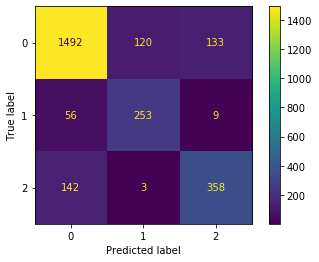

In [60]:
metrics.plot_confusion_matrix(search_lr, X_test, y_test)
plt.show()

### Look at feature importance for each classes 
To see if the model is able to discriminate the classes appropriately

In [61]:
coefs_df = pd.DataFrame(search_lr.best_estimator_.named_steps['lr'].coef_).transpose()

In [62]:
feature_array = search_lr.best_estimator_.named_steps['tfidf'].get_feature_names()

In [63]:
feature_coefs_df = coefs_df.join(pd.DataFrame(feature_array, columns=['feature']))
feature_coefs_df.head(10)

,0,1,2,feature
0,0.002352,-0.005844,0.003492,aa
1,0.002352,-0.005844,0.003492,aaa
2,-0.259052,-0.012660,0.271712,ab
3,0.007254,-0.003124,-0.004131,ab
4,-0.021679,-0.047605,0.069284,aba
5,0.008513,-0.001390,-0.007123,abc
6,0.044173,-0.038578,-0.005595,abd
7,-0.107594,0.143108,-0.035514,abe
8,-0.036320,0.069470,-0.033150,abi
9,0.201640,-0.134361,-0.067279,abl


#### For class 1 (*racism*) and 2 (*sexism*)

In [64]:
feature_racism = feature_coefs_df.loc[:, [1, 'feature']].sort_values(by=1, ascending=False).head(15)
feature_sexism = feature_coefs_df.loc[:, [2, 'feature']].sort_values(by=2, ascending=False).head(15)

display(feature_racism)
display(feature_sexism)

,1,feature
30029,3.321531,sl
30032,2.609274,sla
30036,2.206862,slam
21098,2.105425,musl
33868,2.105425,usli
16681,2.078663,isla
30054,2.061211,slim
21053,2.047848,mu
27136,2.030440,ra
18511,2.010553,lam


,2,feature
29643,2.368254,sex
12063,2.365117,fem
29647,2.342850,sexi
35755,2.287269,xist
35728,1.921479,xi
11640,1.885658,exis
11636,1.883204,exi
35752,1.864107,xis
10435,1.758133,em
17604,1.697761,kat


### Unboxing TF-IDF Vectorizer
#### How are the weights allocated?

In [65]:
feature_vect = search_lr.best_estimator_.named_steps['tfidf'].idf_

In [66]:
vect_df = pd.DataFrame([feature_array, feature_vect]).transpose().sort_values(by=1, ascending = False)

In [67]:
vect_df[vect_df[1] == vect_df[1].max()].head(10)

,0,1
37118,zzzz,9.54325
9022,dyke,9.54325
9011,dyal,9.54325
22718,nsec,9.54325
9013,dyce,9.54325
9014,dyco,9.54325
9015,dycu,9.54325
22715,nsde,9.54325
9018,dyed,9.54325
9019,dyg,9.54325


In [68]:
vect_df[vect_df[1] == vect_df[1].max()].shape

(11548, 2)

- 1/3 of the features in vocab array in Tfidf Vectorizer has the same weights

- Seems like noise

In [69]:
vect_df[vect_df[1] == vect_df[1].max()].shape[0] / vect_df.shape[0]

0.3111075190603195

## Removing blank tweets

In [70]:
tweets_train_noblanks = train[train['tweets_train'] != '']

In [71]:
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(tweets_train_noblanks['tweets_train'], tweets_train_noblanks['label_train'], test_size=0.2, random_state=12)

In [72]:
tweets_train_noblanks.Label.value_counts(normalize = True)

none      0.675100
sexism    0.201357
racism    0.123543
Name: Label, dtype: float64

In [73]:
lr_noblanks = Pipeline(steps = [('tfidf', TfidfVectorizer(analyzer='char', 
                                                          max_df=0.25, 
                                                          ngram_range=(1,4))),
                                
                        ('lr', LogisticRegression(multi_class="auto", 
                                                  solver='lbfgs', 
                                                  class_weight='balanced',
                                                  max_iter=1000,
                                                  random_state=12))])

In [74]:
lr_noblanks.fit(X_train_nb, y_train_nb)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', max_df=0.25,
                                 ngram_range=(1, 4))),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=12))])

In [75]:
lr_noblanks_pred = lr_noblanks.predict(X_test_nb)

In [76]:
print(metrics.classification_report(y_test_nb, lr_noblanks_pred, digits=3))

              precision    recall  f1-score   support

           0      0.876     0.846     0.861      1688
           1      0.638     0.824     0.719       301
           2      0.733     0.691     0.711       517

    accuracy                          0.811      2506
   macro avg      0.749     0.787     0.764      2506
weighted avg      0.818     0.811     0.813      2506



In [77]:
noblanks_coefs_df = pd.DataFrame(lr_noblanks.named_steps['lr'].coef_).transpose()
noblanks_feature_array = lr_noblanks.named_steps['tfidf'].get_feature_names()

noblanks_feature_coefs_df = noblanks_coefs_df.join(pd.DataFrame(noblanks_feature_array, columns=['feature']))

In [78]:
noblanks_racism = noblanks_feature_coefs_df.loc[:, [1, 'feature']].sort_values(by=1, ascending=False).head(15)
noblanks_sexism = noblanks_feature_coefs_df.loc[:, [2, 'feature']].sort_values(by=2, ascending=False).head(15)

display(noblanks_racism)
display(noblanks_sexism)

,1,feature
29911,3.388858,sl
29914,2.628398,sla
29918,2.295880,slam
18468,2.266603,lam
16640,2.173344,isla
20979,2.141450,mu
33753,2.115886,usli
21022,2.115886,musl
16639,2.095739,isl
18467,2.080586,lam


,2,feature
29536,2.417055,sexi
29533,2.337427,sex
12085,2.273094,fem
35630,2.239761,xist
35603,1.932242,xi
11677,1.931465,exi
11681,1.928046,exis
35627,1.909489,xis
16690,1.843598,ist
2179,1.638605,sex


Blank tweets could be due to aggressive preprocessing of the training data (as none of the original tweets were blank). What if stopwords are included instead?

## Logistic Regression with Stopwords

In [79]:
train['tweets_train_nsw'] = tweets_lemmatized

In [80]:
train['tweets_train_nsw'] = train['tweets_train_nsw'].apply(lambda x: ' '.join([w for w in x]))

In [81]:
train.head(10)

,id,Tweets,Label,hashtags,usernames,tweets_train,label_train,tweets_train_nsw
0,7281,The jokes and puns are flying free in this camping episode.\n#mkr #mkr2015,none,#mkr #mkr2015,,joke pun fly free camp episode mkr mkr,0,the joke and pun be fly free in this camp episode mkr mkr
1,7282,#MKR Lets see who the producers think are going to be better TV - Kat or Nikki and Katie??,none,#mkr,,mkr let see producer think go well tv kat nikki katie,0,mkr let see who the producer think be go to be well tv kat or nikki and katie
2,7283,Praying Jac and Shaz do well! They're my faves. #MKR,none,#mkr,,pray jac shaz well theyre faves mkr,0,pray jac and shaz do well theyre my faves mkr
3,7284,RT @realityraver: Pete Evans the Paleo Capitalist has had his cookbook pulled http://t.co/VubeLWZ9l9 #mkr,none,#mkr,@realityraver,pete evans paleo capitalist cookbook pull mkr,0,rt pete evans the paleo capitalist have have his cookbook pull mkr
4,7285,If Kat and Andre stay tonight I will stop watching My Kitchen Rules. #mkr,none,#mkr,,kat andre stay tonight stop watch kitchen rule mkr,0,if kat and andre stay tonight i will stop watch my kitchen rule mkr
5,7286,#mkr Kat is defining fair..... #hypocrite,none,#mkr #hypocrite,,mkr kat define fair hypocrite,0,mkr kat be define fair hypocrite
6,7287,Twist in the plot.. The bottom 2 teams leave!! I think everyone would be happy!! #MKR,none,#mkr,,twist plot bottom team leave think everyone would happy mkr,0,twist in the plot the bottom team leave i think everyone would be happy mkr
7,7288,"Doesn't anyone have a gif of Manu saying ""no you get out"" cos that would be awesome\n#mkr",none,#mkr,,doesnt anyone gif manu say get co would awesome mkr,0,doesnt anyone have a gif of manu say no you get out co that would be awesome mkr
8,7289,How Bianca puts up with Drasko is beyond me. #MKR,none,#mkr,,bianca put drasko beyond mkr,0,how bianca put up with drasko be beyond me mkr
9,7290,What's Irene doing on #mkr?,none,#mkr,,whats irene mkr,0,whats irene do on mkr


In [82]:
train['tweets_train_nsw'].value_counts()

                                                                                                                       213
yes                                                                                                                    21 
rt                                                                                                                     20 
yup                                                                                                                    16 
here                                                                                                                   13 
                                                                                                                       .. 
you can just do that with twitter search unless you be look to not block manually ez enough to write though            1  
how can palestine be free when it be rule by islamofascists that behead gayspractice honor killingmurder opposition    1  
it friday so i b

### Checking blank tweets
The remaining tweets are those that are not as useful in signaling their classes (hyperlinks, usernames, punctuations).

In [83]:
train[train['tweets_train_nsw'] == ''].head(20)

,id,Tweets,Label,hashtags,usernames,tweets_train,label_train,tweets_train_nsw
1247,8528,http://t.co/dALZL6ZuOV,none,,,,0,
1292,8573,http://t.co/daznQZR8Te,none,,,,0,
1380,8661,http://t.co/NXgtqSlchG,none,,,,0,
1580,8861,@sschinke http://t.co/wFqbTK0LGf,none,,@sschinke,,0,
1715,8996,@theomn https://t.co/b5HFOAtfbk,none,,@theomn,,0,
1728,9009,@super_trashbros https://t.co/b5HFOAtfbk,none,,@super_trashbros,,0,
1748,9029,@mvelic https://t.co/b5HFOAtfbk,none,,@mvelic,,0,
1750,9031,@josh_ag @ncweaver https://t.co/b5HFOAtfbk,none,,@josh_ag @ncweaver,,0,
1756,9037,@onebrightlight https://t.co/b5HFOAtfbk,none,,@onebrightlight,,0,
1948,9229,@directhex http://t.co/CAXXUs108l,none,,@directhex,,0,


In [84]:
train[train['tweets_train_nsw'] == '']['Label'].value_counts()

none      211
sexism    2  
Name: Label, dtype: int64

The blank tweets will be removed for training.

In [85]:
tweets_train_nbnsw = train[train['tweets_train_nsw'] != '']

#### Split train test

In [86]:
X_train_nsw, X_test_nsw, y_train_nsw, y_test_nsw = train_test_split(tweets_train_nbnsw['tweets_train_nsw'], tweets_train_nbnsw['label_train'], test_size=0.2, random_state=12)

In [87]:
lr_nsw = Pipeline(steps = [('tfidf', TfidfVectorizer(analyzer='char', 
                                                          max_df=0.25, 
                                                          ngram_range=(1,4))),
                                
                        ('lr', LogisticRegression(multi_class="auto", 
                                                  solver='lbfgs', 
                                                  class_weight='balanced',
                                                  max_iter=1000,
                                                  random_state=12))])

In [88]:
lr_nsw.fit(X_train_nsw, y_train_nsw)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', max_df=0.25,
                                 ngram_range=(1, 4))),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=12))])

In [89]:
lr_nsw_pred = lr_nsw.predict(X_test_nsw)
print(metrics.classification_report(y_test_nsw, lr_nsw_pred, digits=3))

              precision    recall  f1-score   support

           0      0.883     0.853     0.868      1696
           1      0.673     0.848     0.750       310
           2      0.737     0.703     0.719       518

    accuracy                          0.822      2524
   macro avg      0.764     0.801     0.779      2524
weighted avg      0.827     0.822     0.823      2524



In [90]:
nsw_coefs_df = pd.DataFrame(lr_nsw.named_steps['lr'].coef_).transpose()
nsw_feature_array = lr_nsw.named_steps['tfidf'].get_feature_names()

nsw_feature_coefs_df = nsw_coefs_df.join(pd.DataFrame(nsw_feature_array, columns=['feature']))

nsw_racism = nsw_feature_coefs_df.loc[:, [1, 'feature']].sort_values(by=1, ascending=False).head(15)
nsw_sexism = nsw_feature_coefs_df.loc[:, [2, 'feature']].sort_values(by=2, ascending=False).head(15)

display(nsw_racism)
display(nsw_sexism)

,1,feature
30173,3.399014,sl
30176,2.713366,sla
30179,2.277965,slam
16920,2.197214,isla
1245,2.138583,is
16919,2.112099,isl
18689,2.096958,lam
18626,2.029849,la
19213,1.966354,lim
27352,1.966129,ra


,2,feature
12312,2.409761,fem
29815,2.193728,sexi
35983,2.127050,xist
29811,2.107415,sex
35957,1.815155,xi
11786,1.811996,exi
11790,1.800505,exis
35980,1.796385,xis
824,1.725947,fem
17813,1.672416,kat


Comparing the feature importance of the 2 classes for the two models, logit model without stopwords and logit model with stopwords, the former seems to have a stronger differentiation among the n-grams (giving higher weights to the top 5 n-grams). 

The logit model without stopwords will be used for testing. 

# Test on actual Test set

In [91]:
test = pd.read_csv("dataset_test.csv", engine='python')
test.head(10)

,id,Tweets,Label
0,5014,#mkr at least there are judging honestly,none
1,5015,At the end of this Steve is going to run away to Mexico and go into witness protection #MKR,none
2,5016,Catching up on #MKR. Did Nikki &amp; Katie get a script to say the things they are saying because I wouldn't be caught dead saying any of that!,none
3,5017,Has anyone made a Twitter account for Rob's hat yet? #MKR,none
4,5020,"Will someone pls assist Colin in the washing of his hair. Sorry Colin, big fan but pls... Some shampoo mate! #mkr",none
5,5026,#mkr if they had to walk up and down there steps to use the loo all night..\n2 much effort @Sarah_jane666,none
6,5027,Cream and crumbs on a plate....work it gurls #MKR,none
7,5028,I'm done - won't bother with the rest of this pathetic shit show #mkr,none
8,5029,"“@TodClarey: lemon ""tart"" looks like shit #MKR”\n\nPlease- don't hold back - tell it how you see it",none
9,5030,Why do teams look shocked when they announce the final score will be revealed at a different location? Haven't they watched #mkr before?,none


In [92]:
test.shape

(3206, 3)

##### Same distribution of classes as per Training data

In [93]:
test.Label.value_counts()

none      2186
sexism    633 
racism    387 
Name: Label, dtype: int64

In [94]:
test.Label.value_counts(normalize=True)

none      0.681847
sexism    0.197442
racism    0.120711
Name: Label, dtype: float64

## Preprocess Tweets in Test set

In [95]:
test_clean_tokens = clean_tokenizer(test['Tweets'])

In [96]:
test_lemmatized = [[lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in t] for t in test_clean_tokens]

In [97]:
tweets_test = [[w for w in t if w not in stopword_list and w != ('rt')] for t in test_lemmatized]

In [98]:
test['tweets_test'] = tweets_test
test['tweets_test'] = test['tweets_test'].apply(lambda x: ' '.join([w for w in x]))

In [99]:
test = test[test['tweets_test'] != ''] # remove blank tweets
test.head(10)

,id,Tweets,Label,tweets_test
0,5014,#mkr at least there are judging honestly,none,mkr least judging honestly
1,5015,At the end of this Steve is going to run away to Mexico and go into witness protection #MKR,none,end steve go run away mexico go witness protection mkr
2,5016,Catching up on #MKR. Did Nikki &amp; Katie get a script to say the things they are saying because I wouldn't be caught dead saying any of that!,none,catch mkr nikki amp katie get script say thing say wouldnt caught dead say
3,5017,Has anyone made a Twitter account for Rob's hat yet? #MKR,none,anyone make twitter account robs hat yet mkr
4,5020,"Will someone pls assist Colin in the washing of his hair. Sorry Colin, big fan but pls... Some shampoo mate! #mkr",none,someone pls assist colin wash hair sorry colin big fan pls shampoo mate mkr
5,5026,#mkr if they had to walk up and down there steps to use the loo all night..\n2 much effort @Sarah_jane666,none,mkr walk step use loo night much effort
6,5027,Cream and crumbs on a plate....work it gurls #MKR,none,cream crumb platework gurls mkr
7,5028,I'm done - won't bother with the rest of this pathetic shit show #mkr,none,im wont bother rest pathetic shit show mkr
8,5029,"“@TodClarey: lemon ""tart"" looks like shit #MKR”\n\nPlease- don't hold back - tell it how you see it",none,lemon tart look like shit mkr please dont hold back tell see
9,5030,Why do teams look shocked when they announce the final score will be revealed at a different location? Haven't they watched #mkr before?,none,team look shock announce final score reveal different location havent watch mkr


## Looking at clean Test data

In [100]:
test_r = test[test['Label'] == 'racism']['tweets_test'].str.split(expand=True).stack().value_counts()[:10]
test_r_norm = test[test['Label'] == 'racism']['tweets_test'].str.split(expand=True).stack().value_counts(normalize=True)[:10]

pd.DataFrame([test_r, round(test_r_norm*100, 2)]).T.rename(columns={0: "Token Count", 1: "Distribution (%)"})

,Token Count,Distribution (%)
islam,177.0,5.34
muslim,99.0,2.98
murder,56.0,1.69
religion,50.0,1.51
not,42.0,1.27
prophet,38.0,1.15
people,36.0,1.09
mohammed,33.0,0.99
year,30.0,0.90
like,29.0,0.87


In [101]:
test_s = test[test['Label'] == 'sexism']['tweets_test'].str.split(expand=True).stack().value_counts()[:10]
test_s_norm = test[test['Label'] == 'sexism']['tweets_test'].str.split(expand=True).stack().value_counts(normalize=True)[:10]

pd.DataFrame([test_s, round(test_s_norm*100, 2)]).T.rename(columns={0: "Token Count", 1: "Distribution (%)"})

,Token Count,Distribution (%)
mkr,671.0,12.20
kat,217.0,3.95
girl,88.0,1.60
blonde,65.0,1.18
go,56.0,1.02
like,54.0,0.98
not,52.0,0.95
get,49.0,0.89
face,47.0,0.85
andre,45.0,0.82


## Label Encode target variable

In [102]:
test['label_test'] = le.transform(test['Label'])

In [103]:
test.head(10)

,id,Tweets,Label,tweets_test,label_test
0,5014,#mkr at least there are judging honestly,none,mkr least judging honestly,0
1,5015,At the end of this Steve is going to run away to Mexico and go into witness protection #MKR,none,end steve go run away mexico go witness protection mkr,0
2,5016,Catching up on #MKR. Did Nikki &amp; Katie get a script to say the things they are saying because I wouldn't be caught dead saying any of that!,none,catch mkr nikki amp katie get script say thing say wouldnt caught dead say,0
3,5017,Has anyone made a Twitter account for Rob's hat yet? #MKR,none,anyone make twitter account robs hat yet mkr,0
4,5020,"Will someone pls assist Colin in the washing of his hair. Sorry Colin, big fan but pls... Some shampoo mate! #mkr",none,someone pls assist colin wash hair sorry colin big fan pls shampoo mate mkr,0
5,5026,#mkr if they had to walk up and down there steps to use the loo all night..\n2 much effort @Sarah_jane666,none,mkr walk step use loo night much effort,0
6,5027,Cream and crumbs on a plate....work it gurls #MKR,none,cream crumb platework gurls mkr,0
7,5028,I'm done - won't bother with the rest of this pathetic shit show #mkr,none,im wont bother rest pathetic shit show mkr,0
8,5029,"“@TodClarey: lemon ""tart"" looks like shit #MKR”\n\nPlease- don't hold back - tell it how you see it",none,lemon tart look like shit mkr please dont hold back tell see,0
9,5030,Why do teams look shocked when they announce the final score will be revealed at a different location? Haven't they watched #mkr before?,none,team look shock announce final score reveal different location havent watch mkr,0


## Predict on Test Set

In [104]:
pred = lr_noblanks.predict(test['tweets_test'])

In [105]:
print(metrics.classification_report(test['label_test'], pred, digits=3))

              precision    recall  f1-score   support

           0      0.828     0.914     0.869      2186
           1      0.997     0.837     0.910       387
           2      0.591     0.438     0.503       633

    accuracy                          0.810      3206
   macro avg      0.805     0.729     0.760      3206
weighted avg      0.801     0.810     0.801      3206



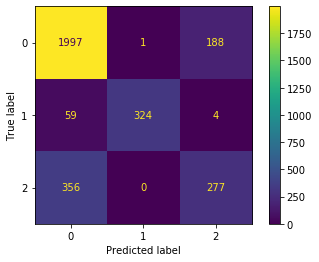

In [106]:
metrics.plot_confusion_matrix(lr_noblanks, test['tweets_test'], test['label_test'])
plt.show()

### Exploring prediction for class 2

#### False Negative: All class 2 (sexism) misclassifications were misclassifed as class 0 (none).

In [107]:
test['pred'] = pred

In [108]:
fn_2 = test[(test['label_test'] == 2) & (test['pred'] != 2)] 

In [109]:
fn_2.head(10)

,id,Tweets,Label,tweets_test,label_test,pred
2574,1868,The face of very ugly promo girls ! Faces like cats arsehole #mkr excited to see them@go down tonight...literally http://t.co/HgoJrfoIeO,sexism,face ugly promo girl face like cat arsehole mkr excite see tonightliterally,2,0
2576,1872,Stop saying dumb blondes with pretty faces as you need a pretty face to pull that off!!!! #mkr,sexism,stop say dumb blonde pretty face need pretty face pull mkr,2,0
2577,1873,#mkr Omg there restaurant looks like a a little girls room oh my! Gosh,sexism,mkr omg restaurant look like little girl room oh gosh,2,0
2578,1881,"Drasko only likes his mum's hot pot, especially when she's drunk and unconscious #MKR",sexism,drasko like mum hot pot especially shes drunk unconscious mkr,2,0
2581,1886,I think they're deconstraucted Pro . . . mowhores #MKR,sexism,think theyre deconstraucted pro mowhores mkr,2,0
2583,1891,#mkr deconstructed by girls that have deconstructed brains ! Nearly brought up my dinner when I saw that crap on the plate,sexism,mkr deconstruct girl deconstruct brain nearly brought dinner saw crap plate,2,0
2587,1901,Wish these blondes were in that How To Get Away With Murder show....#MKR,sexism,wish blonde get away murder showmkr,2,0
2588,1903,"In the words of former contestant @whatsnextjake , Katie and Nikki need to calm their farm. #MKR",sexism,word former contestant katie nikki need calm farm mkr,2,0
2590,1912,"I dislike Kat more than the blondes who are going to tell us they're hot another 50,000 times #MKR #notaustraliasnexttopmodel",sexism,dislike kat blonde go tell u theyre hot another time mkr notaustraliasnexttopmodel,2,0
2592,1929,I cannot stop looking at Nikki's dreadful black crooked bra #MKR #MKR2015,sexism,cannot stop look nikkis dreadful black crooked bra mkr mkr,2,0


In [110]:
fn_2['tweets_test'].str.split(expand=True).stack().value_counts().head(10)

mkr       382
kat       109
andre     40 
like      35 
get       35 
go        34 
nikki     31 
amp       31 
think     28 
blonde    28 
dtype: int64

Most tokens individually do not strongly signal "sexism", so they might not be picked up on by the model. It seems like the context is important. 

How the words are stringed together might be important too (e.g. id 1891, the tokens "deconstructed brain" refers to the noun "girl", and this relationship is not picked up by the character n-gram model).  

#### Based on token frequency, 'kat' seems to have a higher distribution in the testing set (3.95%) compared to in the training set.

Comparing 'kat' in train set

In [111]:
train[(train['tweets_train'].str.contains('kat')) & (train['Label'] == 'sexism')]

,id,Tweets,Label,hashtags,usernames,tweets_train,label_train,tweets_train_nsw
10295,2562,I hope Kat breaks both of her ankles. #MKR,sexism,#mkr,,hope kat break ankle mkr,2,i hope kat break both of her ankle mkr
10296,2563,@initials_games Big news! Wait does kat actually still think she can cook? #mkr,sexism,#mkr,@initials_games,big news wait kat actually still think cook mkr,2,big news wait do kat actually still think she can cook mkr
10299,2566,#MKR those pieces to camera are recorded after the event. Kat knows she gets smacked down and she STILL gloats like a crazy Bond villain,sexism,#mkr,,mkr piece camera record event kat know get smack still gloat like crazy bond villain,2,mkr those piece to camera be record after the event kat know she get smack down and she still gloat like a crazy bond villain
10300,2567,my hate for kat is getting stronger and stronger every time i watch her. #MKR,sexism,#mkr,,hate kat get strong strong every time watch mkr,2,my hate for kat be get strong and strong every time i watch her mkr
10301,2568,#mkr all Kat needs now is a witch's hat! Let's see how they go.,sexism,#mkr,,mkr kat need witch hat let see go,2,mkr all kat need now be a witch hat let see how they go
...,...,...,...,...,...,...,...,...
12784,5095,And Annie is a total fruit cake! RT @lismarie56: Kat is so delusional that Annie has a better grip on reality ? #MKR2015 #mkr,sexism,#mkr2015 #mkr,@lismarie56,annie total fruit cake kat delusional annie well grip reality mkr mkr,2,and annie be a total fruit cake rt kat be so delusional that annie have a well grip on reality mkr mkr
12799,5319,My #MKR take: Nikki and Katie should be the poster children for the obliviously mediocre http://t.co/VtkzDvl7ys http://t.co/VspCN4rvjX,sexism,#mkr,,mkr take nikki katie poster child obliviously mediocre,2,my mkr take nikki and katie should be the poster child for the obliviously mediocre
12804,5347,"Omg. All those girl teams and 2 couples. Hahaha, poor Kats husband and Lloyd. #MKR",sexism,#mkr,,omg girl team couple hahaha poor kat husband lloyd mkr,2,omg all those girl team and couple hahaha poor kat husband and lloyd mkr
12824,5884,"RT @immichaeldixon: Katie and Nikki, smug, vacuous, condescending, putrid, self congratulatory and bland. There. #MKR",sexism,#mkr,@immichaeldixon,katie nikki smug vacuous condescend putrid self congratulatory bland mkr,2,rt katie and nikki smug vacuous condescend putrid self congratulatory and bland there mkr


In [112]:
# estimated frequency of 'kat' in training set
(len(train[(train['tweets_train'].str.contains('kat')) & (train['Label'] == 'sexism')])/len(train))*100

0.9042014186608466

Words like "kat" refers to a person. Perhaps a more nuanced cleaning of the data would be helpful. For instance, converting names to their genders based on the other tokens in the document ("kat"..."she"...) could reduce noise in the data. Especially for sexism, the (hypothesised) key words are usually gender related.

#### False Positives: Where class 0 was misclassifed as class 2.

In [113]:
fp_2 = test[(test['label_test'] == 0) & (test['pred'] == 2)] 

In [114]:
fp_2.head(20)

,id,Tweets,Label,tweets_test,label_test,pred
2,5016,Catching up on #MKR. Did Nikki &amp; Katie get a script to say the things they are saying because I wouldn't be caught dead saying any of that!,none,catch mkr nikki amp katie get script say thing say wouldnt caught dead say,0,2
14,5035,#mkr 3 the girls are gonna be pissed about that,none,mkr girl gonna piss,0,2
16,5041,Katie and Nikki can't cook!!! #MKR,none,katie nikki cant cook mkr,0,2
42,5093,That blonde chick from #mkr is wearing my hot pink #becandbridge dress!! Lol,none,blonde chick mkr wear hot pink becandbridge dress lol,0,2
79,5133,Hashtag killerblondes is the dickiest hashtag in all #MKR history... Seriously... Why not #butcherthemodels,none,hashtag killerblondes dickiest hashtag mkr history seriously not butcherthemodels,0,2
83,5137,Can't even make your own chicken stock... #MKR,none,cant even make chicken stock mkr,0,2
85,5139,@Matt_Cooke86 Nutrition is key to closing the .#Aboriginal life expectancy gap http://t.co/IHtNiRJMa9 @croakeyblog http://t.co/ktnqAD0TM3,none,nutrition key closing aboriginal life expectancy gap,0,2
177,5232,Sounds good. #killerblondes #mkr,none,sound good killerblondes mkr,0,2
210,5265,Sassy girls rule. #killerblonds #MKR,none,sassy girl rule killerblonds mkr,0,2
242,5310,"RT @AmyMunce: #MKR maybe you girls should go back to cutting up cows and pigs, don't quit your day job!! @mykitchenrules",none,mkr maybe girl go back cut cow pig dont quit day job,0,2


In [115]:
fp_2['tweets_test'].str.split(expand=True).stack().value_counts().head(10)

mkr              198
kat              73 
girl             61 
not              23 
killerblondes    20 
go               18 
make             17 
like             16 
say              16 
cant             15 
dtype: int64

On another hand, the model picked up on common n-grams that were wrongly classified as sexism. Certain tweets seem to have a negative sentiment on females, but are not necessarily sexist (e.g. id 5322, 5353). They seem like personal opinion about people on the show who happen to be female. The model may have been overfitted for this class. 

### In general, sexism seems to be harder to detect than racism. Perhaps more nuanced cleaning of the data is needed. The model could also be further tuned or another model, like SVM, could be introduced. 